In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Leveraging Qiskit Runtime

From [https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html](https://qiskit.org/documentation/nature/tutorials/07_leveraging_qiskit_runtime.html)

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
import qiskit_nature 
qiskit_nature.settings.use_pauli_sum_op=False

## Problem specification: LiH molecule

In [3]:
bond_distance = 2.5  # in Angstrom

# specify driver
driver = PySCFDriver(
    atom=f"Li 0 0 0; H 0 0 {bond_distance}",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
problem = driver.run()

# specify active space transformation
active_space_trafo = ActiveSpaceTransformer(
    num_electrons=problem.num_particles, num_spatial_orbitals=3
)

# transform the electronic structure problem
problem = active_space_trafo.transform(problem)

mapper = ParityMapper(num_particles=problem.num_particles)

reduced_op = mapper.map(problem.hamiltonian.second_q_op())



/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Essentials/Chemistry/test-env/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


### Classical reference solution

In [4]:

from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
np_solver = NumPyMinimumEigensolver()

exact_run = np_solver.compute_minimum_eigenvalue(operator=reduced_op)
ground_state_energy = exact_run.eigenvalue.real

In [5]:
print(exact_run)

{   'aux_operators_evaluated': None,
    'eigenstate': Statevector([-8.73246827e-17+5.30389777e-18j,
             -4.79491008e-17+3.90257957e-17j,
             -9.41156560e-17+1.50556597e-16j,
             -5.60649544e-18-1.25450595e-17j,
             -4.23527564e-17-3.00319480e-17j,
             -7.00714779e-01-7.04388714e-01j,
              1.21564870e-04+1.22202250e-04j,
             -3.90333085e-02-3.92379650e-02j,
              2.91593910e-16+2.47746599e-18j,
              1.21564870e-04+1.22202250e-04j,
              2.59655791e-03+2.61017199e-03j,
              3.11785498e-04+3.13420228e-04j,
              4.22252017e-17-7.48646651e-18j,
             -3.90333085e-02-3.92379650e-02j,
              3.11785498e-04+3.13420228e-04j,
              5.77056700e-02+5.80082280e-02j],
            dims=(2, 2, 2, 2)),
    'eigenvalue': -8.408630642330651}


### VQE

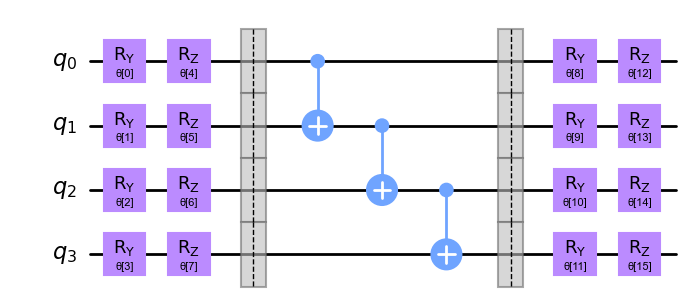

In [8]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement="linear", insert_barriers=True)
ansatz.decompose().draw("mpl", style="clifford")

In [10]:
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

# fix random seeds for reproducibility

np.random.seed(5)
algorithm_globals.random_seed = 5

In [11]:
from qiskit_algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

initial_point = np.random.random(ansatz.num_parameters)

#### Local VQE

In [12]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

estimator = Estimator()

local_vqe = VQE(
    estimator,
    ansatz,
    optimizer,
    initial_point=initial_point,
)

local_vqe_result = local_vqe.compute_minimum_eigenvalue(operator=reduced_op)

In [13]:
print(local_vqe_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -8.223473554828136,
    'optimal_circuit': <qiskit.circuit.library.n_local.efficient_su2.EfficientSU2 object at 0x288b9f580>,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 0.03671411585691057,
                              ParameterVectorElement(θ[6]): -0.07226276027069443,
                              ParameterVectorElement(θ[11]): 1.6513894757682503,
                              ParameterVectorElement(θ[8]): -0.001367362830109891,
                              ParameterVectorElement(θ[5]): -1.2448717685335418,
                              ParameterVectorElement(θ[10]): 1.4911794525552169,
                              ParameterVectorElement(θ[15]): -0.9015111185490204,
                              ParameterVectorElement(θ[12]): 0.794399567507286,
                              ParameterVectorElement(θ[9]): 0.8033795622429846,
                              ParameterVectorElement(θ[1

#### Runtime VQE

In [14]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

estimates = []

try:
    with Session(service=service, backend=backend, max_time="1h") as session:

        def vqe_callback(eval_count, params, est_value, metadata):
            print(f'Eval count: {eval_count}, estimated value = {est_value}, metadata = {metadata}')
            estimates.append(est_value)

        estimator = Estimator(session=session)

        vqe = VQE(
            estimator,
            ansatz,
            optimizer,
            initial_point=initial_point,
            callback=vqe_callback
        )
        vqe_result = vqe.compute_minimum_eigenvalue(operator=reduced_op)
        print(vqe_result)

except Exception as e:
    print(e)
    print(estimates)


Eval count: 1, estimated value = -2.9057991034551733, metadata = {'variance': 3.373892006144516, 'shots': 4000}
Eval count: 2, estimated value = -1.9413984429758804, metadata = {'variance': 1.9724790180073386, 'shots': 4000}
Eval count: 3, estimated value = -2.6120906931276573, metadata = {'variance': 3.081040680533611, 'shots': 4000}
Eval count: 4, estimated value = -2.323729251907235, metadata = {'variance': 2.709130436583318, 'shots': 4000}
Eval count: 5, estimated value = -1.7919395673361065, metadata = {'variance': 2.439106509479651, 'shots': 4000}
Eval count: 6, estimated value = -3.0252816604795236, metadata = {'variance': 3.17625977372375, 'shots': 4000}
Eval count: 7, estimated value = -1.5782218242303077, metadata = {'variance': 1.8254265538800745, 'shots': 4000}
Eval count: 8, estimated value = -3.2651341213312968, metadata = {'variance': 3.8680517544063324, 'shots': 4000}
Eval count: 9, estimated value = -2.134855849292116, metadata = {'variance': 2.5090518980653327, 'shots

In [15]:
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

estimator = Estimator()

def vqe_callback(eval_count, params, est_value, metadata):
    print(f'Eval count: {eval_count}, estimated value = {est_value}, metadata = {metadata}')


local_vqe = VQE(
    estimator,
    ansatz,
    optimizer,
    initial_point=initial_point,
    callback=vqe_callback
)

local_vqe_result = local_vqe.compute_minimum_eigenvalue(operator=reduced_op)

print(local_vqe_result)

Eval count: 1, estimated value = -2.0930477113103985, metadata = {}
Eval count: 2, estimated value = -2.6821475299970317, metadata = {}
Eval count: 3, estimated value = -2.9757544202351722, metadata = {}
Eval count: 4, estimated value = -1.9540749696964856, metadata = {}
Eval count: 5, estimated value = -2.1660553824615487, metadata = {}
Eval count: 6, estimated value = -2.7112948404095842, metadata = {}
Eval count: 7, estimated value = -2.0950620067296577, metadata = {}
Eval count: 8, estimated value = -2.697665247368459, metadata = {}
Eval count: 9, estimated value = -2.024157555774103, metadata = {}
Eval count: 10, estimated value = -2.759094429843048, metadata = {}
Eval count: 11, estimated value = -2.774394501033794, metadata = {}
Eval count: 12, estimated value = -2.0425420364278724, metadata = {}
Eval count: 13, estimated value = -2.7944088278108126, metadata = {}
Eval count: 14, estimated value = -1.9793578609608575, metadata = {}
Eval count: 15, estimated value = -2.7594043154

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>